### Step 1. 데이터 구하기

- 주식데이터, 기상데이터 등을 이용해 직접 구해야합니다.

데이터는 https://finance.yahoo.com/quote/NQ=F?p=NQ=F 에서 2010년 1월 1일부터 2019년 12월 31일까지로 잡았습니다.

In [2]:
import os

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

In [3]:
import pandas as pd

df = pd.read_csv(csv_file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1865.50,1889.00,1865.50,1886.75,1886.75,205157.0
1,2010-01-05,1886.50,1890.25,1876.00,1885.25,1885.25,208698.0
2,2010-01-06,1885.25,1891.75,1872.25,1878.50,1878.50,261274.0
3,2010-01-07,1877.75,1880.50,1865.75,1877.50,1877.50,241321.0
4,2010-01-08,1877.50,1892.50,1865.00,1890.00,1890.00,268934.0


### Step 2. 기본 통계분석으로 이상치 찾기

- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

#### 한 단계 더 나아가기

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

In [4]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         529
High         529
Low          529
Close        529
Adj Close    529
Volume       529
dtype: int64

In [5]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 3037
삭제 후 데이터 길이(일자수): 2508


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

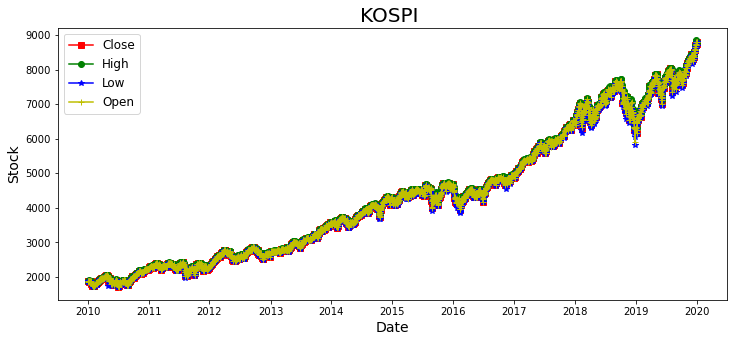

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

그래프만 보았을때 특별한 이상치는 보이지 않는 것 같습니다.  
z-test를 통해 정규분포 여부를 확인해보도록 하겠습니다.

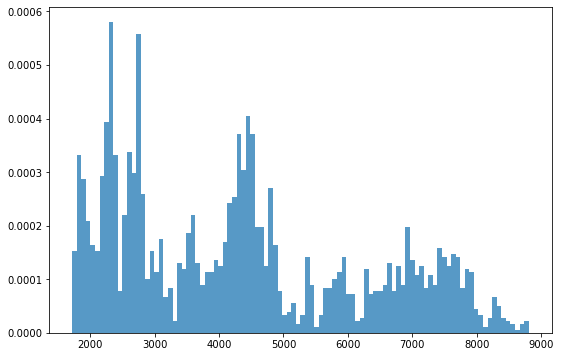

In [9]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [10]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


### Time series decomposition 적용하기

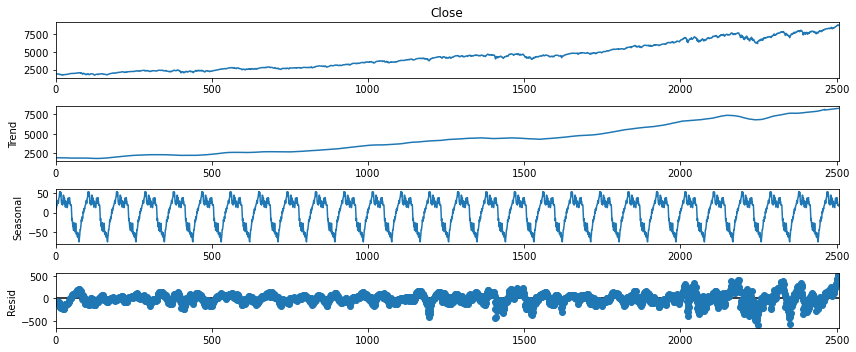

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=91, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

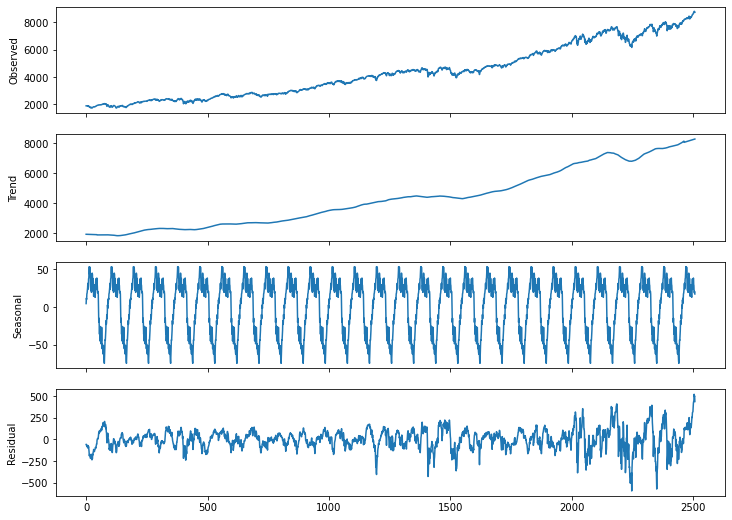

In [13]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

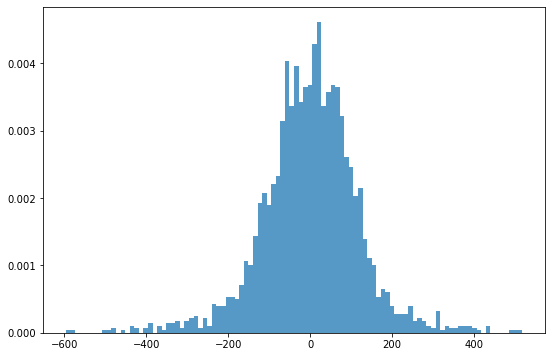

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [15]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

0.31557577693791966 0.7523245260070077


p 값이 0.05이상인 아주 지극히 정규분포를 따르고 있는 형태의 데이터를 갖고 있는것 같습니다.

이제 신뢰구간을 통해 이상치를 찾도록 하겠습니다

In [17]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: 0.7452049087107769 표준편차: 118.25943858365225
이상치 갯수: 40


In [18]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

1195   2014-10-15
1196   2014-10-16
1408   2015-08-24
1409   2015-08-25
1524   2016-02-09
2024   2018-02-08
2059   2018-04-02
2163   2018-08-29
2165   2018-08-31
2183   2018-09-27
2184   2018-09-28
2185   2018-10-01
2186   2018-10-02
2187   2018-10-03
2221   2018-11-20
2239   2018-12-19
2240   2018-12-20
2241   2018-12-21
2242   2018-12-26
2243   2018-12-27
2244   2018-12-28
2245   2018-12-31
2246   2019-01-02
2247   2019-01-03
2322   2019-04-23
2323   2019-04-24
2330   2019-05-03
2347   2019-05-29
2349   2019-05-31
2350   2019-06-03
2351   2019-06-04
2352   2019-06-05
2500   2019-12-19
2501   2019-12-20
2502   2019-12-22
2503   2019-12-23
2504   2019-12-26
2505   2019-12-27
2506   2019-12-29
2507   2019-12-30
Name: Date, dtype: datetime64[ns]

In [49]:
marker_on = df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

In [51]:
marker_on.shape

(40,)

marker_on_1= marker_on.values.tolist()

marker_on_1

In [60]:
df.Date[:]

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
2503   2019-12-23
2504   2019-12-26
2505   2019-12-27
2506   2019-12-29
2507   2019-12-30
Name: Date, Length: 2508, dtype: datetime64[ns]

ValueError: Can only compare identically-labeled Series objects

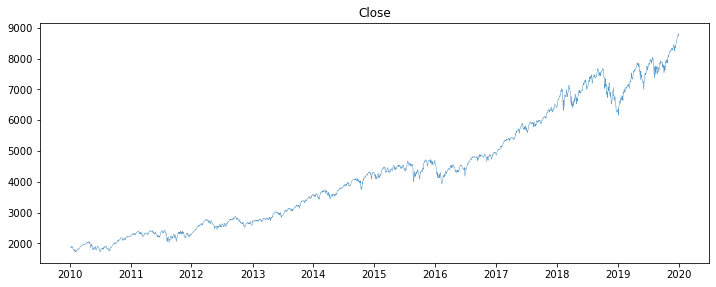

In [59]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Close')
plt.plot(df.Date, df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(df.Date, df.Close, markevery = [df.Date[:] == marker_on])

### Step 3. Unsupervised Clustering 으로 이상치 찾기

- k-means로 분석하기
- DBSCAN으로 분석하기

#### 한 단계 더 나아가기  

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

### Step 4. LSTM 오토인코더로 이상치 찾기

- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

#### 한 단계 더 나아가기

- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기